# Identifying 5'-end adapter sequences

Several of our test col-0 datasets have had an RNA adapter sequence ligated to the 5' end of the mRNa samples. The hope is that the nanopore will sequence into these adapter sequences allowing us to identify a subset of nanopore reads that are the full-length sequences of mRNAs and cature the true 5' end of these sequences. 

To identify these reads I took the simplistic approach of blasting the RNA adapter sequence against the base-called reads with very lax parameters that I can then filter and subset post-hoc.

So, here I'm going to load the blast results, make some plots to decide the most appropriate set of filtering criteria, identify the read ids that pass the filtering and then subset the input read alignments to extract these full length read candidtes. 

I'll also make a few plots to see if the filtering suggests that we're correctly identifying full length reads.

## The first 5' adapter ligated sample

For the first of our 5' adapter ligated samples we are fotunate to have the same tissue sequenced without adapter in col-0 sample 01 (tissue id 2916). This means we can run exactly the same adapter identification process on the un-adapted data as a negative control and make sure that the filters we are using to identify the full-length sequences are performing better on the adapted data than on unadapted data.

In [1]:
import pandas as pd
import numpy as np
import os, sys, pysam, json, matplotlib, subprocess, glob
%matplotlib inline
import matplotlib.pyplot as plt

blast_colnames = ('qaccver', 'saccver', 'pident', 'length', 'mismatch', 'gapopen',
                  'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore')
blast_dtypes = {'qaccver':str, 'saccver':str, 'pident':np.float64,'length':np.int32,
                'mismatch':np.int32, 'gapopen':np.int32, 'qstart':np.int32, 
                'qend':np.int32, 'sstart':np.int32, 'send':np.int32, 
                'evalue':np.float64, 'bitscore':np.float64}

adapt_bam = "../../datasets/20180411_1432_20180911_FAH84603_5adapterLIG_Col0_2916/aligned_data/TAIR10/" \
            "201902_col0_2916_5adapter_exp2.bam"
adapt_datasets = "../../datasets/20180411_1432_20180911_FAH84603_5adapterLIG_Col0_2916/adapter_blast/TAIR10/" \
                 "201902_col0_2916_5adapter_exp2_five-prime_softclipped_blast_hits.tsv"

neg_control_bam = "../../datasets/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq/aligned_data/TAIR10/" \
                  "201901_col0_2916.bam"
neg_control_datasets = "../../datasets/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq/adapter_blast/TAIR10/" \
                       "201901_col0_2916_five-prime_softclipped_blast_hits.tsv"

# read in the blast results
adapt_data = pd.read_table(adapt_datasets, header=None, names=blast_colnames, dtype=blast_dtypes)
neg_controls = pd.read_table(neg_control_datasets, header=None, names=blast_colnames, dtype=blast_dtypes)


# get the number of unique reads  with alignments for each dataset
def countUniqueReadsAligned(bamfile):
    thisbam = pysam.AlignmentFile(bamfile, "rb")
    readids = []
    for read in thisbam.fetch():
        readids.append(read.query_name)
    return(len(np.unique(np.array(readids))))

adapt_nMaligned_reads = countUniqueReadsAligned(adapt_bam)
neg_nMaligned_reads = countUniqueReadsAligned(neg_control_bam)

With the data loaded what I'd like to see first if how many hits we have from each dataset and then plot the distribution of blast e-value scores against threshold values some of the other columns. I'm going to make these into some nice little movies for presentations too so lets make a quick function for making these plots...

In [2]:
def eval_v_col(ds1, ds2, erange=(-11,5), esteps=150, col="length", xlim=(5,40), ylim=(0,20000),
               textxy=(15,15000), bins=np.arange(38)+3.5, outputname="eval_v_len",
               outpath="../supplementary/movies/", pathtoffmpeg='ffmpeg', overwrite=False):
    
    if not overwrite and os.path.isfile("{}.mp4".format(os.path.join(outpath, outputname))):
        print("{}.mp4 already exists, not overwriting.".format(os.path.join(outpath, outputname)))
    else:
        print("Encoding movie to {}.mp4 ...".format(os.path.join(outpath, outputname)))

        counter=1
        evals = np.linspace(erange[0],erange[1],num=esteps)
        for i in evals:
            fig = plt.figure(figsize=(10,5))
            x=plt.hist(ds1[np.log10(ds1["evalue"])<i][col], bins=bins, color='blue', alpha=0.5)
            y=plt.hist(ds2[np.log10(ds2["evalue"])<i][col], bins=bins, color='gold', alpha=0.5)
            plt.xlim(xlim)
            plt.ylim(ylim)
            plt.ylabel("Count")
            plt.xlabel(col)
            plt.text(textxy[0],textxy[1],r"$log_{10}(evalue)$<"+"{:.2f}".format(i))
            outprefix = os.path.join(outpath,outputname)
            filename = f"{outprefix}_{counter:03d}.png"
            plt.savefig(filename, dpi=300, format="png", transparent=False)
            plt.close()
            counter+=1

        cpath = os.getcwd()
        os.chdir(outpath)
        cmd = [pathtoffmpeg, '-y', '-framerate', '15', '-i', '{}_%03d.png'.format(outputname), '-r',
               '30', '-pix_fmt', 'yuv420p', '{}.mp4'.format(outputname)]
        encode = subprocess.Popen(cmd, stderr=subprocess.PIPE, stdout=subprocess.PIPE)
        out = encode.communicate()
        for file_name in glob.glob("*.png"):
            os.remove(file_name)
        os.chdir(cpath)

OK, lets use this function to output a bunch of figures at set thresholds for a few columns and turn these into movies. This takes quite a while so best not to re-run it every time.

In [4]:
# evalue distribution vs blast hit length threshold
eval_v_col(adapt_data, neg_controls, outputname="eval_v_lev")
# evalue distribution vs blast hit length threshold zoomed evalue range
eval_v_col(adapt_data, neg_controls, erange=(2,5), outputname="eval_v_lev_zoom")
# evalue distribution vs subject hit start potision
eval_v_col(adapt_data, neg_controls, col="sstart", xlim=(0,100), ylim=(0,33000),
           textxy=(15,28000), bins=np.arange(101)+0.5, outputname="eval_v_sstart")
# evalue distribution vs subject hit end potision
eval_v_col(adapt_data, neg_controls, col="send", xlim=(0,100), ylim=(0,40000),
           textxy=(15,28000), bins=np.arange(101)+0.5, outputname="eval_v_send")

../supplementary/movies/eval_v_lev.mp4 already exists, not overwriting.
../supplementary/movies/eval_v_lev_zoom.mp4 already exists, not overwriting.
../supplementary/movies/eval_v_sstart.mp4 already exists, not overwriting.
../supplementary/movies/eval_v_send.mp4 already exists, not overwriting.


## E-value threshold

OK, so lets take a closer look at the number of reads as a function of the evalue and contrast it with the negative control dataset.

/cluster/gjb_lab/nschurch/cluster_installs/miniconda2/envs/python3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


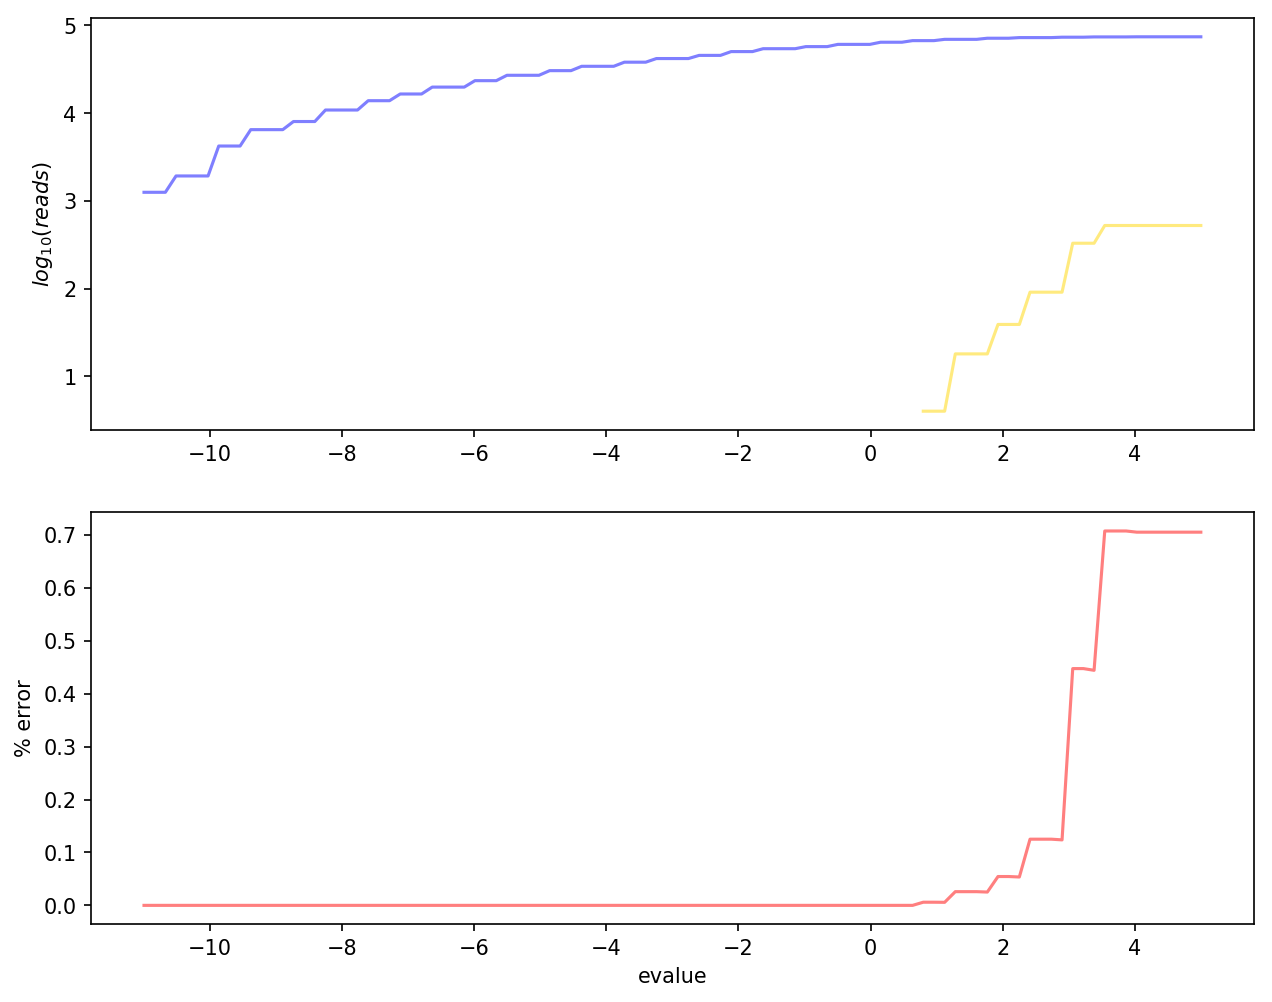

In [5]:
steps = np.linspace(-11,5,num=100)
len_alt_fbhwa=[]
len_alt_fbhwoa=[]
for step in steps:
    start_ind = (np.log10(adapt_data["evalue"])<step)&(adapt_data["length"]>10)&(adapt_data["sstart"]==1)
    x = len(adapt_data[start_ind])
    end_ind = (np.log10(adapt_data["evalue"])<step)&(adapt_data["length"]>10)&(adapt_data["send"]==1)
    y = len(adapt_data[end_ind])
    len_alt_fbhwa.append(x+y)
    neg_start_ind = (np.log10(neg_controls["evalue"])<step)&(neg_controls["length"]>10)&(neg_controls["sstart"]==1)
    x = len(neg_controls[neg_start_ind])
    neg_end_ind = (np.log10(neg_controls["evalue"])<step)&(neg_controls["length"]>10)&(neg_controls["send"]==1)
    y = len(neg_controls[neg_end_ind])
    len_alt_fbhwoa.append(x+y)

fig = plt.figure(figsize=(10,8), dpi=150)
plt.subplot(211)
x=plt.plot(steps, np.log10(len_alt_fbhwa), color='blue', alpha=0.5)
y=plt.plot(steps, np.log10(len_alt_fbhwoa), color='gold', alpha=0.5)
ylab = plt.ylabel(r"$log_{10}(reads)$")
plt.subplot(212)
z=plt.plot(steps, (np.array(len_alt_fbhwoa)/np.array(len_alt_fbhwa))*100, color='red', alpha=0.5)
xlab = plt.xlabel("evalue")
ylab = plt.ylabel(r"% error")

OK, so a combination of evalue, hit length, and possibly subject start/end filters seems like a good way to go here. Lets work out some numbers showing the number of reads that are sub-selected as we apply eyeballed threshold values for each for these various thresholds. We'll normalize here by the number of millions of aligned reads sowe can convert the paired replicates to a signal-to-noise...

In [6]:
total_reads = np.array([adapt_nMaligned_reads, neg_nMaligned_reads])
n_blast_hits = np.array([len(np.unique(adapt_data["saccver"])),len(np.unique(neg_controls["saccver"]))])

ind = (adapt_data["length"]>10)
n_ind = (neg_controls["length"]>10)
n_len_lt_10 = np.array([len(np.unique(adapt_data[ind]["saccver"])), len(np.unique(neg_controls[n_ind]["saccver"]))])

ind = (np.log10(adapt_data["evalue"])<2)&(adapt_data["length"]>10)
n_ind = (np.log10(neg_controls["evalue"])<2)&(neg_controls["length"]>10)
n_eval_lt_100 = np.array([len(np.unique(adapt_data[ind]["saccver"])),len(np.unique(neg_controls[n_ind]["saccver"]))])

ind = ((adapt_data["sstart"]==1)|(adapt_data["send"]==1))&(np.log10(adapt_data["evalue"])<2)&(adapt_data["length"]>10)
n_ind = ((neg_controls["sstart"]==1)|(neg_controls["send"]==1))&(np.log10(neg_controls["evalue"])<2)&(neg_controls["length"]>10)
n_spos_eq_1 = np.array([len(np.unique(adapt_data[ind]["saccver"])), len(np.unique(neg_controls[n_ind]["saccver"]))])

ind = ((adapt_data["qstart"]==1)|(adapt_data["qend"]==1))&((adapt_data["sstart"]==1)|(adapt_data["send"]==1))&(np.log10(adapt_data["evalue"])<2)&(adapt_data["length"]>10)
n_ind = ((neg_controls["qstart"]==1)|(neg_controls["qend"]==1))&((neg_controls["sstart"]==1)|(neg_controls["send"]==1))&(np.log10(neg_controls["evalue"])<2)&(neg_controls["length"]>10)
n_apos_eq_1 = np.array([len(np.unique(adapt_data[ind]["saccver"])), len(np.unique(neg_controls[n_ind]["saccver"]))])

def printline(tup, rowtext, libsizes=total_reads):
    norm_ratio = (tup[0]/(libsizes[0]/1E6)) / (tup[1]/(libsizes[1]/1E6))
    print("{:>25}:{:>25}{:>25}{:>25.2f}".format(rowtext, tup[0], tup[1], norm_ratio))

print("{:>25} {:>25}{:>25}{:>25}".format("", "Adapter Tagged Data", "Control Data", "Normalized S/N ratio"))
printline(total_reads, "total reads")
printline(n_blast_hits, "total blastn hits")
printline(n_len_lt_10, "hit length > 10bp")
printline(n_eval_lt_100, "e-value < 100")
printline(n_spos_eq_1, "adapter start/end == 1")
printline(n_apos_eq_1, "read start/end == 1")

                                Adapter Tagged Data             Control Data     Normalized S/N ratio
              total reads:                   341779                   984172                     1.00
        total blastn hits:                   227166                    47797                    13.69
        hit length > 10bp:                   205440                    10657                    55.51
            e-value < 100:                   192778                     1060                   523.69
   adapter start/end == 1:                    71568                       39                  5284.21
      read start/end == 1:                    20963                        1                 60364.15


Awesome, it seem like the 'adapter start/end == 1' stage igive a really good few-thousand-fold enrichment so that look like a good spot to position out filters and still give a good number of reads. We might want to relax these thresholds a little later if things are going well.

## Filtering the original bam files for just full-length reads

The next job then is to filter the original bam files for just the full-length reads....

In [7]:
def indexBam(bamfile, rootpath):
    cpath = os.getcwd()
    os.chdir(rootpath)
    cmd = ['samtools', 'index', bamfile]
    encode = subprocess.Popen(cmd, stderr=subprocess.PIPE, stdout=subprocess.PIPE)
    out = encode.communicate()
    os.chdir(cpath)

def filterBam(filtids, bamfile, filtbam, otherbam, outpath):
    
    #fl_adapt_bam = "../../datasets/20180411_1432_20180911_FAH84603_5adapterLIG_Col0_2916/aligned_data/TAIR10/" \
    #               "201902_col0_2916_5adapter_exp2_fulllength.bam"
    #o_adapt_bam = "../../datasets/20180411_1432_20180911_FAH84603_5adapterLIG_Col0_2916/aligned_data/TAIR10/" \
    #              "201902_col0_2916_5adapter_exp2_short.bam"

    inbam = pysam.AlignmentFile(bamfile, "rb")
    flbam = pysam.AlignmentFile(os.path.join(outpath,filtbam), "wb", template=inbam)
    obam = pysam.AlignmentFile(os.path.join(outpath,otherbam), "wb", template=inbam)

    # filter the files
    allreadids=[]
    rev=[]
    fwd=[]
    skipped=[]
    for read in inbam.fetch():
        allreadids.append(read.query_name)
        if read.query_name in filtids:
            if read.is_reverse:
                rev.append(read.query_name)
            else:
                fwd.append(read.query_name)
            flbam.write(read)
        else:
            obam.write(read)
            skipped.append(read.query_name)

    inbam.close()
    flbam.close()
    obam.close()
    
    indexBam(filtbam, outpath)
    indexBam(otherbam, outpath)
    return(allreadids,fwd,rev,skipped)

adapt_datasets = "../../datasets/20180411_1432_20180911_FAH84603_5adapterLIG_Col0_2916/adapter_blast/TAIR10/" \
                 "201902_col0_2916_5adapter_exp2_five-prime_softclipped_blast_hits.tsv"
adapt_data = pd.read_table(adapt_datasets, header=None, names=blast_colnames, dtype=blast_dtypes)

# filter the first data file
ind = ((adapt_data["sstart"]==1)|(adapt_data["send"]==1))&(np.log10(adapt_data["evalue"])<2)&(adapt_data["length"]>10)
filtids = np.unique(adapt_data[ind]["saccver"])

fl_adapt_bam = "201902_col0_2916_5adapter_exp2_fulllength.bam"
o_adapt_bam = "201902_col0_2916_5adapter_exp2_short.bam"

filtres = filterBam(filtids, adapt_bam, fl_adapt_bam, o_adapt_bam, "../supplementary/fulllength_data/")

## The second 5' adapter ligated sample

We generated a second dataset with the adaper sequences on (tissue id 2918), this time with significantly more reads. Lets run this data through the same proceedure....

In [8]:
adapt_bam = "../../datasets/20180508_1522_20180508_FAH82422_5adapt_lig_mRNA_2918/aligned_data/TAIR10/" \
            "201902_col0_2918_5adapter.bam"
adapt_datasets = "../../datasets/20180508_1522_20180508_FAH82422_5adapt_lig_mRNA_2918/adapter_blast/TAIR10/" \
                 "201902_col0_2918_5adapter_five-prime_softclipped_blast_hits.tsv"

neg_control_bam = "../../datasets/20180416_1534_20180415_FAH83697_mRNA_WT_Col0_2918/aligned_data/TAIR10/" \
                  "201901_col0_2918.bam"
neg_control_datasets = "../../datasets/20180416_1534_20180415_FAH83697_mRNA_WT_Col0_2918/adapter_blast/TAIR10/" \
                       "201901_col0_2918_five-prime_softclipped_blast_hits.tsv"

# read in the blast results
adapt_data = pd.read_table(adapt_datasets, header=None, names=blast_colnames, dtype=blast_dtypes)
neg_controls = pd.read_table(neg_control_datasets, header=None, names=blast_colnames, dtype=blast_dtypes)

# get the number of unique reads  with alignments for each dataset
def countUniqueReadsAligned(bamfile):
    thisbam = pysam.AlignmentFile(bamfile, "rb")
    readids = []
    for read in thisbam.fetch():
        readids.append(read.query_name)
    return(len(np.unique(np.array(readids))))

adapt_nMaligned_reads = countUniqueReadsAligned(adapt_bam)
neg_nMaligned_reads = countUniqueReadsAligned(neg_control_bam)

In [9]:
total_reads = np.array([adapt_nMaligned_reads, neg_nMaligned_reads])
n_blast_hits = np.array([len(np.unique(adapt_data["saccver"])),len(np.unique(neg_controls["saccver"]))])

ind = (adapt_data["length"]>10)
n_ind = (neg_controls["length"]>10)
n_len_lt_10 = np.array([len(np.unique(adapt_data[ind]["saccver"])), len(np.unique(neg_controls[n_ind]["saccver"]))])

ind = (np.log10(adapt_data["evalue"])<2)&(adapt_data["length"]>10)
n_ind = (np.log10(neg_controls["evalue"])<2)&(neg_controls["length"]>10)
n_eval_lt_100 = np.array([len(np.unique(adapt_data[ind]["saccver"])),len(np.unique(neg_controls[n_ind]["saccver"]))])

ind = ((adapt_data["sstart"]==1)|(adapt_data["send"]==1))&(np.log10(adapt_data["evalue"])<2)&(adapt_data["length"]>10)
n_ind = ((neg_controls["sstart"]==1)|(neg_controls["send"]==1))&(np.log10(neg_controls["evalue"])<2)&(neg_controls["length"]>10)
n_spos_eq_1 = np.array([len(np.unique(adapt_data[ind]["saccver"])), len(np.unique(neg_controls[n_ind]["saccver"]))])

ind = ((adapt_data["qstart"]==1)|(adapt_data["qend"]==1))&((adapt_data["sstart"]==1)|(adapt_data["send"]==1))&(np.log10(adapt_data["evalue"])<2)&(adapt_data["length"]>10)
n_ind = ((neg_controls["qstart"]==1)|(neg_controls["qend"]==1))&((neg_controls["sstart"]==1)|(neg_controls["send"]==1))&(np.log10(neg_controls["evalue"])<2)&(neg_controls["length"]>10)
n_apos_eq_1 = np.array([len(np.unique(adapt_data[ind]["saccver"])), len(np.unique(neg_controls[n_ind]["saccver"]))])

def printline(tup, rowtext, libsizes=total_reads):
    norm_ratio = (tup[0]/(libsizes[0]/1E6)) / (tup[1]/(libsizes[1]/1E6))
    print("{:>25}:{:>25}{:>25}{:>25.2f}".format(rowtext, tup[0], tup[1], norm_ratio))

print("{:>25} {:>25}{:>25}{:>25}".format("", "Adapter Tagged Data", "Control Data", "Normalized S/N ratio"))
printline(total_reads, "total reads")
printline(n_blast_hits, "total blastn hits")
printline(n_len_lt_10, "hit length > 10bp")
printline(n_eval_lt_100, "e-value < 100")
printline(n_spos_eq_1, "adapter start/end == 1")
printline(n_apos_eq_1, "read start/end == 1")

                                Adapter Tagged Data             Control Data     Normalized S/N ratio
              total reads:                   549429                   745243                     1.00
        total blastn hits:                   361746                    83506                     5.88
        hit length > 10bp:                   336118                    11752                    38.79
            e-value < 100:                   318858                      650                   665.38
   adapter start/end == 1:                   112977                       15                 10216.10
      read start/end == 1:                    32451                        1                 44016.39


In [10]:
# filter the first data file
adapt_datasets = "../../datasets/20180508_1522_20180508_FAH82422_5adapt_lig_mRNA_2918/adapter_blast/TAIR10/" \
                 "201902_col0_2918_5adapter_five-prime_softclipped_blast_hits.tsv"
adapt_data = pd.read_table(adapt_datasets, header=None, names=blast_colnames, dtype=blast_dtypes)

ind = ((adapt_data["sstart"]==1)|(adapt_data["send"]==1))&(np.log10(adapt_data["evalue"])<2)&(adapt_data["length"]>10)
filtids = np.unique(adapt_data[ind]["saccver"])

fl_adapt_bam = "201902_col0_2918_5adapter_fulllength.bam"
o_adapt_bam = "201902_col0_2918_5adapter_short.bam"

filtres = filterBam(filtids, adapt_bam, fl_adapt_bam, o_adapt_bam, "../supplementary/fulllength_data/")

# Plotting length distributions for the full-length and partial-length reads

In [11]:
# run 1 plot
flbam_filename = "../supplementary/fulllength_data/201902_col0_2916_5adapter_exp2_fulllength.bam"
otherbam_filename = "../supplementary/fulllength_data/201902_col0_2916_5adapter_exp2_short.bam"

fl_readlens=[]
flbam = pysam.AlignmentFile(flbam_filename, "rb")
for read in flbam.fetch():
    fl_readlens.append(read.query_alignment_length)
flbam.close()
fl_readlens = np.array(fl_readlens)

other_readlens=[]
obam = pysam.AlignmentFile(otherbam_filename, "rb")
for read in obam.fetch():
    other_readlens.append(read.query_alignment_length)
obam.close()
other_readlens = np.array(other_readlens)

Text(0.5, 0, 'aligned read length (bp)')

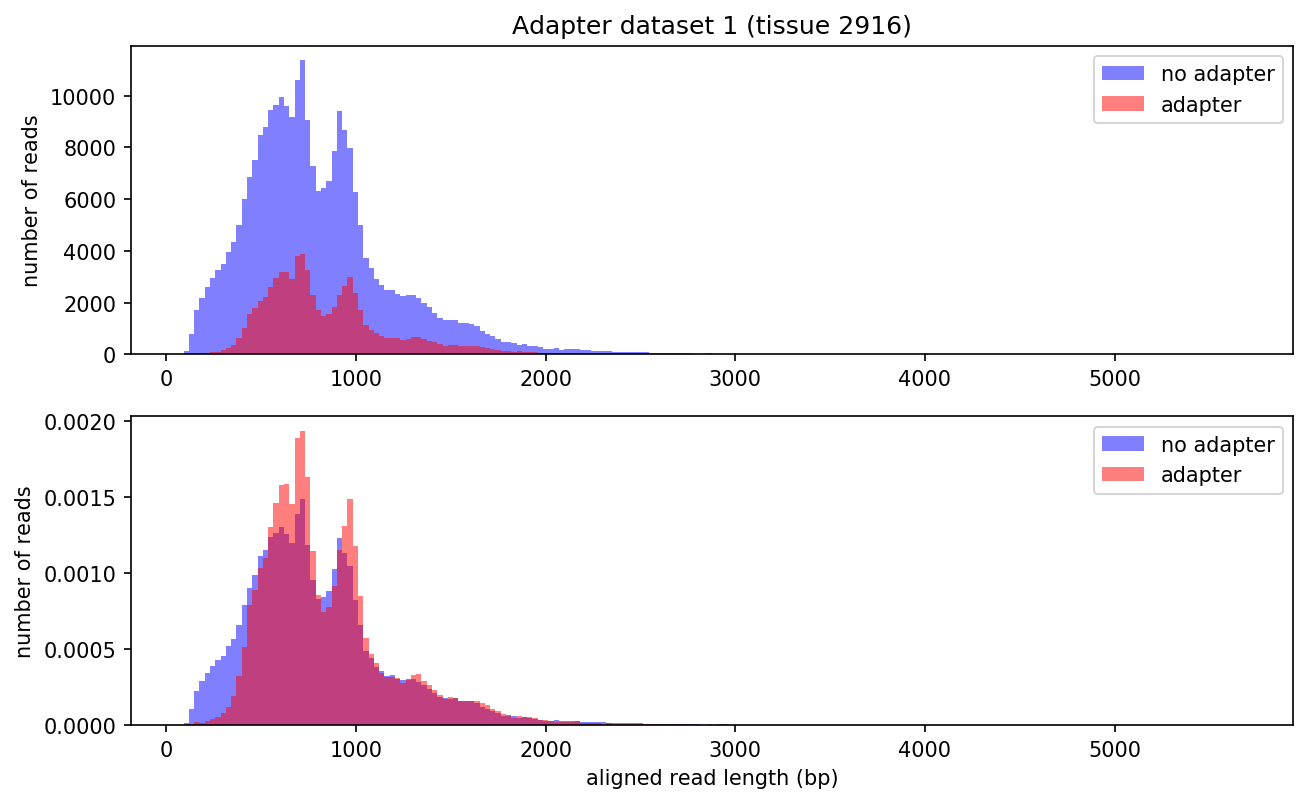

In [12]:
# plot the data
fig = plt.figure(figsize=(10,6),dpi=150)
ax1 = plt.subplot(211)
a = plt.hist(other_readlens, bins=200, color="blue", alpha=0.5, label='no adapter')
b = plt.hist(fl_readlens, bins=a[1], color="red", alpha=0.5, label='adapter')
plt.legend()
plt.title('Adapter dataset 1 (tissue 2916)')
plt.ylabel("number of reads")
plt.setp(ax1.get_xticklabels(), visible=True)
ax2 = plt.subplot(212, sharex=ax1)
a = plt.hist(other_readlens, bins=200, color="blue", alpha=0.5, density=True, label='no adapter')
b = plt.hist(fl_readlens, bins=a[1], color="red", alpha=0.5, density=True, label='adapter')
plt.legend()
plt.ylabel("number of reads")
plt.xlabel("aligned read length (bp)")

In [13]:
print("Mean full-length-read read lengths: {:.2f}".format(fl_readlens.mean()))
print("Mean other-read read lengths: {:.2f}".format(other_readlens.mean()))

Mean full-length-read read lengths: 853.63
Mean other-read read lengths: 806.59


In [14]:
# run 2 plot
flbam_filename = "../supplementary/fulllength_data/201902_col0_2918_5adapter_fulllength.bam"
otherbam_filename = "../supplementary/fulllength_data/201902_col0_2918_5adapter_short.bam"

fl_readlens=[]
flbam = pysam.AlignmentFile(flbam_filename, "rb")
for read in flbam.fetch():
    fl_readlens.append(read.query_alignment_length)
flbam.close()
fl_readlens = np.array(fl_readlens)

other_readlens=[]
obam = pysam.AlignmentFile(otherbam_filename, "rb")
for read in obam.fetch():
    other_readlens.append(read.query_alignment_length)
obam.close()
other_readlens = np.array(other_readlens)

Text(0.5, 0, 'aligned read length (bp)')

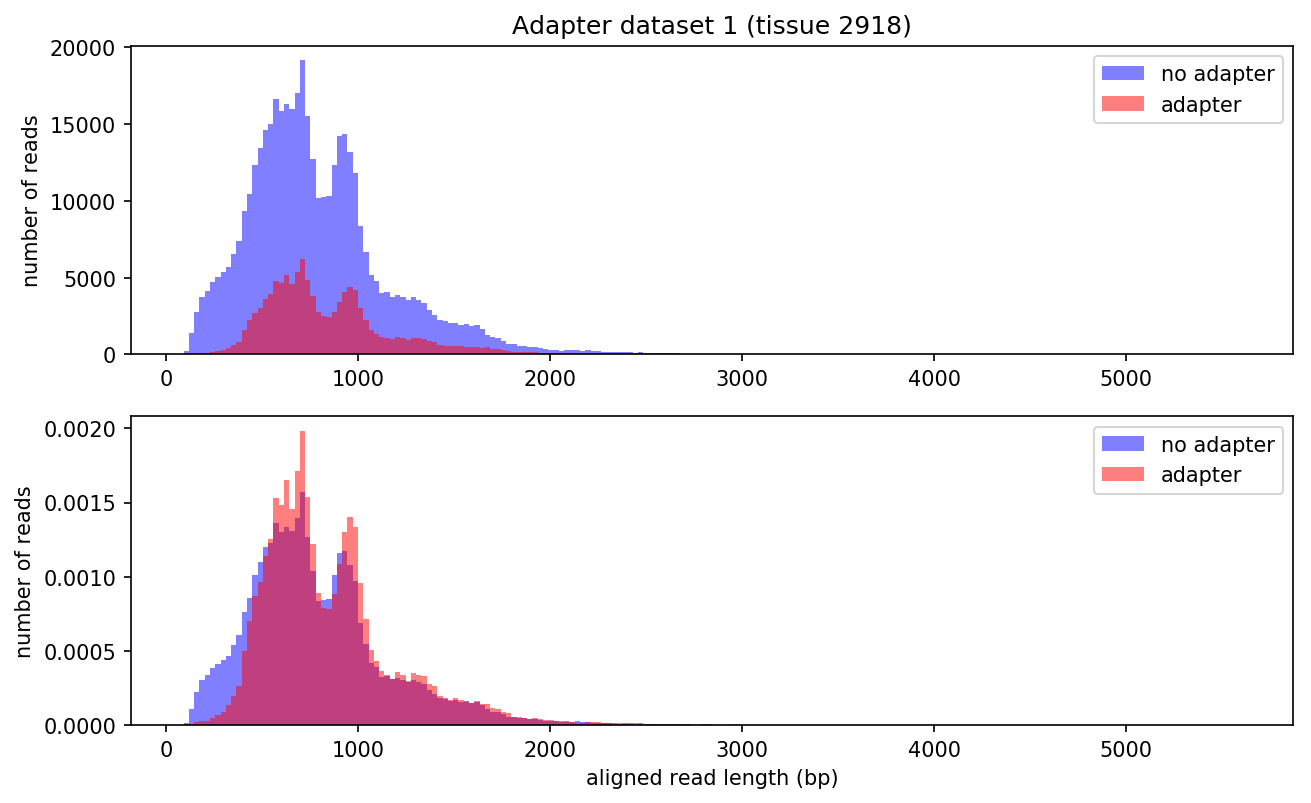

In [16]:
# plot the data
fig = plt.figure(figsize=(10,6),dpi=150)
ax1 = plt.subplot(211)
a = plt.hist(other_readlens, bins=200, color="blue", alpha=0.5, label='no adapter')
b = plt.hist(fl_readlens, bins=a[1], color="red", alpha=0.5, label='adapter')
plt.legend()
plt.title('Adapter dataset 1 (tissue 2918)')
plt.ylabel("number of reads")
plt.setp(ax1.get_xticklabels(), visible=True)
ax2 = plt.subplot(212, sharex=ax1)
a = plt.hist(other_readlens, bins=200, color="blue", alpha=0.5, density=True, label='no adapter')
b = plt.hist(fl_readlens, bins=a[1], color="red", alpha=0.5, density=True, label='adapter')
plt.legend()
plt.ylabel("number of reads")
plt.xlabel("aligned read length (bp)")

In [17]:
print("Mean full-length-read read lengths: {:.2f}".format(fl_readlens.mean()))
print("Mean other-read read lengths: {:.2f}".format(other_readlens.mean()))

Mean full-length-read read lengths: 854.63
Mean other-read read lengths: 795.31


# Relaxing the filters

I think the histograms above clearly show that we are being too restrictive with our filters. Lets relax them and see how that changes things.

In [30]:
# filter the first data file
adapt_bam = "../../datasets/20180411_1432_20180911_FAH84603_5adapterLIG_Col0_2916/aligned_data/TAIR10/" \
            "201902_col0_2916_5adapter_exp2.bam"
adapt_datasets = "../../datasets/20180411_1432_20180911_FAH84603_5adapterLIG_Col0_2916/adapter_blast/TAIR10/" \
                 "201902_col0_2916_5adapter_exp2_five-prime_softclipped_blast_hits.tsv"
adapt_data = pd.read_table(adapt_datasets, header=None, names=blast_colnames, dtype=blast_dtypes)

# filter the first data file
ind = (np.log10(adapt_data["evalue"])<2)&(adapt_data["length"]>10)
filtids = np.unique(adapt_data[ind]["saccver"])

fl_adapt_bam = "201902_col0_2916_5adapter_exp2_fulllength_relaxed.bam"
o_adapt_bam = "201902_col0_2916_5adapter_exp2_short_relaxed.bam"

filtres = filterBam(filtids, adapt_bam, fl_adapt_bam, o_adapt_bam, "../supplementary/fulllength_data/")

In [31]:
# run 1 plot - relaxed filters
flbam_filename = "../supplementary/fulllength_data/201902_col0_2916_5adapter_exp2_fulllength_relaxed.bam"
otherbam_filename = "../supplementary/fulllength_data/201902_col0_2916_5adapter_exp2_short_relaxed.bam"

fl_readlens=[]
flbam = pysam.AlignmentFile(flbam_filename, "rb")
for read in flbam.fetch():
    fl_readlens.append(read.query_alignment_length)
flbam.close()
fl_readlens = np.array(fl_readlens)

other_readlens=[]
obam = pysam.AlignmentFile(otherbam_filename, "rb")
for read in obam.fetch():
    other_readlens.append(read.query_alignment_length)
obam.close()
other_readlens = np.array(other_readlens)

Text(0.5, 0, 'aligned read length (bp)')

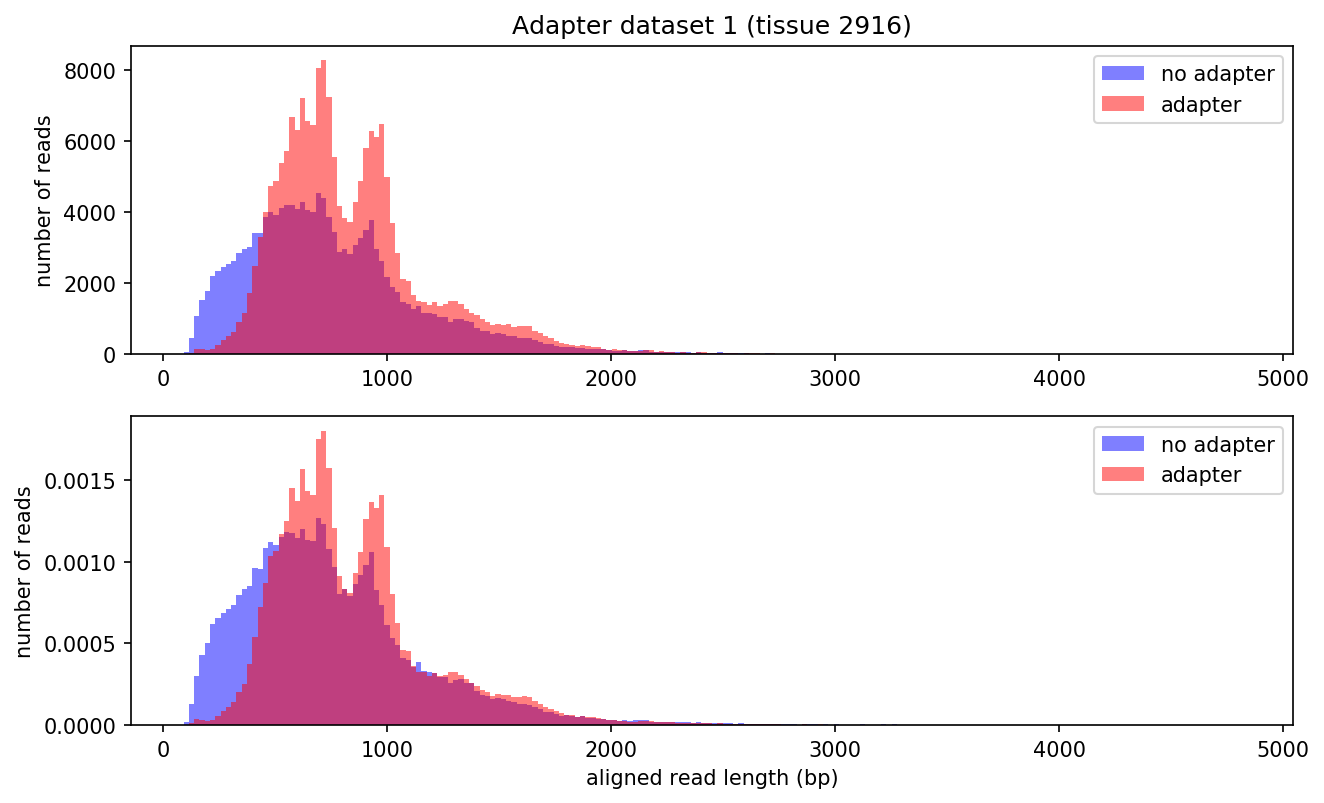

In [32]:
# plot the data
fig = plt.figure(figsize=(10,6),dpi=150)
ax1 = plt.subplot(211)
a = plt.hist(other_readlens, bins=200, color="blue", alpha=0.5, label='no adapter')
b = plt.hist(fl_readlens, bins=a[1], color="red", alpha=0.5, label='adapter')
plt.legend()
plt.title('Adapter dataset 1 (tissue 2916)')
plt.ylabel("number of reads")
plt.setp(ax1.get_xticklabels(), visible=True)
ax2 = plt.subplot(212, sharex=ax1)
a = plt.hist(other_readlens, bins=200, color="blue", alpha=0.5, density=True, label='no adapter')
b = plt.hist(fl_readlens, bins=a[1], color="red", alpha=0.5, density=True, label='adapter')
plt.legend()
plt.ylabel("number of reads")
plt.xlabel("aligned read length (bp)")

In [33]:
print("Mean full-length-read read lengths: {:.2f}".format(fl_readlens.mean()))
print("Mean other-read read lengths: {:.2f}".format(other_readlens.mean()))

Mean full-length-read read lengths: 855.48
Mean other-read read lengths: 766.15


In [34]:
# filter the second data file
adapt_bam = "../../datasets/20180508_1522_20180508_FAH82422_5adapt_lig_mRNA_2918/aligned_data/TAIR10/" \
            "201902_col0_2918_5adapter.bam"
adapt_datasets = "../../datasets/20180508_1522_20180508_FAH82422_5adapt_lig_mRNA_2918/adapter_blast/TAIR10/" \
                 "201902_col0_2918_5adapter_five-prime_softclipped_blast_hits.tsv"
adapt_data = pd.read_table(adapt_datasets, header=None, names=blast_colnames, dtype=blast_dtypes)

ind = (np.log10(adapt_data["evalue"])<2)&(adapt_data["length"]>10)
filtids = np.unique(adapt_data[ind]["saccver"])

fl_adapt_bam = "201902_col0_2918_5adapter_fulllength_relaxed.bam"
o_adapt_bam = "201902_col0_2918_5adapter_short_relaxed.bam"

filtres = filterBam(filtids, adapt_bam, fl_adapt_bam, o_adapt_bam, "../supplementary/fulllength_data/")

In [ ]:
# run 2 plot
flbam_filename = "../supplementary/fulllength_data/201902_col0_2918_5adapter_fulllength_relaxed.bam"
otherbam_filename = "../supplementary/fulllength_data/201902_col0_2918_5adapter_short_relaxed.bam"

fl_readlens=[]
flbam = pysam.AlignmentFile(flbam_filename, "rb")
for read in flbam.fetch():
    fl_readlens.append(read.query_alignment_length)
flbam.close()
fl_readlens = np.array(fl_readlens)

other_readlens=[]
obam = pysam.AlignmentFile(otherbam_filename, "rb")
for read in obam.fetch():
    other_readlens.append(read.query_alignment_length)
obam.close()
other_readlens = np.array(other_readlens)

Text(0.5, 0, 'aligned read length (bp)')

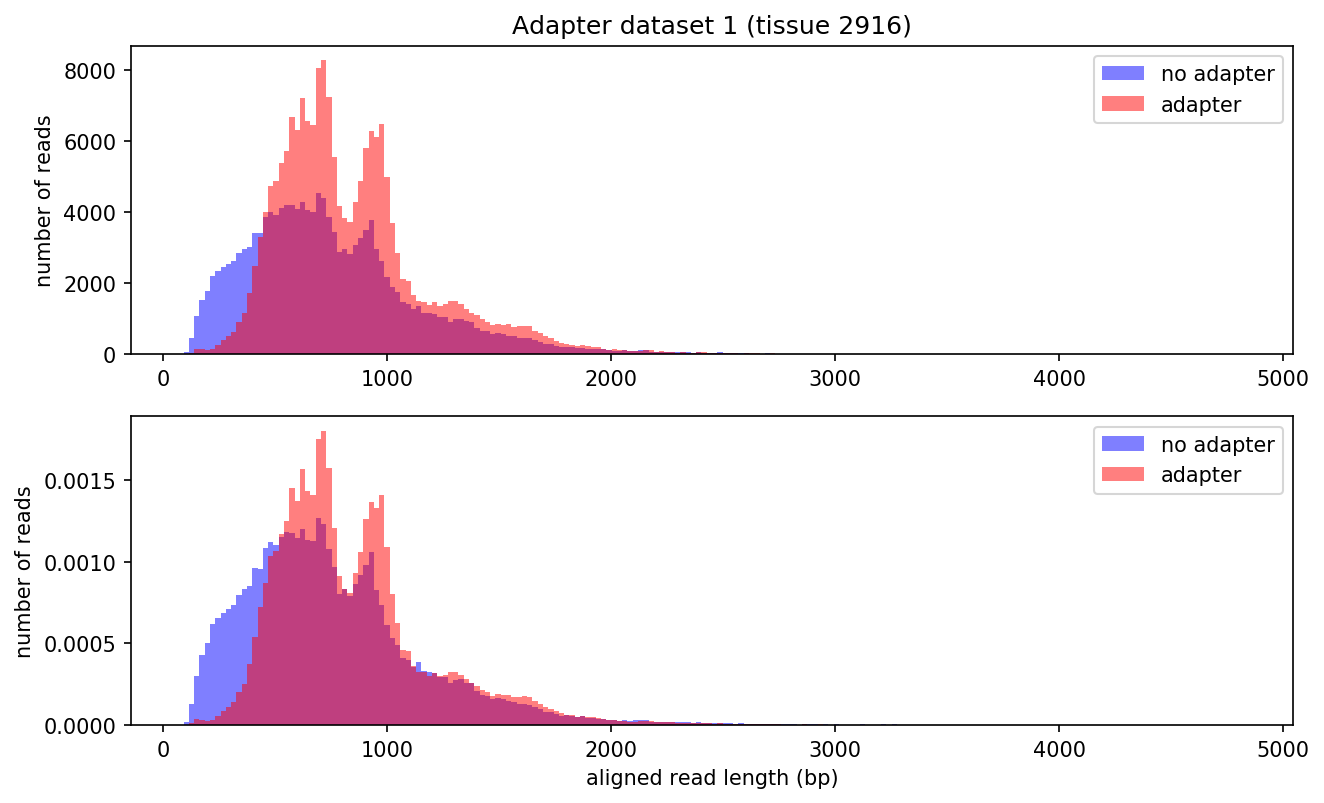

In [35]:
# plot the data
fig = plt.figure(figsize=(10,6),dpi=150)
ax1 = plt.subplot(211)
a = plt.hist(other_readlens, bins=200, color="blue", alpha=0.5, label='no adapter')
b = plt.hist(fl_readlens, bins=a[1], color="red", alpha=0.5, label='adapter')
plt.legend()
plt.title('Adapter dataset 1 (tissue 2916)')
plt.ylabel("number of reads")
plt.setp(ax1.get_xticklabels(), visible=True)
ax2 = plt.subplot(212, sharex=ax1)
a = plt.hist(other_readlens, bins=200, color="blue", alpha=0.5, density=True, label='no adapter')
b = plt.hist(fl_readlens, bins=a[1], color="red", alpha=0.5, density=True, label='adapter')
plt.legend()
plt.ylabel("number of reads")
plt.xlabel("aligned read length (bp)")

# Counting the expression of full length adapter-containing reads and reads without an adapter in RCA

In [49]:
def countReadsInRegion(listofbams, ref, start, stop, strand):
    
    counts=[]
    for bamfile in listofbams:
        bam = pysam.AlignmentFile(bamfile, "rb")
        sensecounts=0
        asensecounts=0
        for read in bam.fetch(ref, start, stop):
            if (strand=="-" or strand=="rev"):
                if read.is_reverse:
                    if read.reference_end > start and read.reference_end < stop:
                        sensecounts+=1
                else:
                    if read.reference_start > start and read.reference_start < stop:
                        asensecounts+=1
            elif (strand=="+" or strand=="fwd"):
                if read.is_reverse:
                    if read.reference_end > start and read.reference_end < stop:
                        asensecounts+=1
                else:
                    if read.reference_start > start and read.reference_start < stop:
                        sensecounts+=1
        counts.append((sensecounts,asensecounts))
    return(counts)

rep1_fl_bam = "../supplementary/fulllength_data/201902_col0_2916_5adapter_exp2_fulllength.bam"
rep1_o_bam = "../supplementary/fulllength_data/201902_col0_2916_5adapter_exp2_short.bam"
rep2_fl_bam = "../supplementary/fulllength_data/201902_col0_2918_5adapter_fulllength.bam"
rep2_o_bam = "../supplementary/fulllength_data/201902_col0_2918_5adapter_short.bam"

rca_endreg_count = countReadsInRegion([rep1_fl_bam, rep1_o_bam, rep2_fl_bam, rep2_o_bam], "2", 16573350, 16573416, '-')
rca_flreg_count = countReadsInRegion([rep1_fl_bam, rep1_o_bam, rep2_fl_bam, rep2_o_bam], "2", 16573417, 16573692, '-')

In [55]:
total_fl_reads = rca_flreg_count[0][0]+rca_flreg_count[1][0]+rca_flreg_count[2][0]+rca_flreg_count[3][0]
total_fl_adapter_reads = rca_flreg_count[0][0]+rca_flreg_count[2][0]
total_wo_adapters = rca_endreg_count[1][0]+rca_endreg_count[3][0]

print("Total identified adapter tagged full length reads: {}".format(total_fl_adapter_reads))
print("Total unidentified adapter tagged full length reads: {}".format(total_fl_reads-total_fl_adapter_reads))
print("Total reads without adapters: {}".format(total_wo_adapters))
print("Percentage of full length reads with identified adapters: {:.2f}%".format(100*(total_fl_adapter_reads/total_fl_reads)))

Total identified adapter tagged full length reads: 599
Total unidentified adapter tagged full length reads: 1197
Total reads without adapters: 1108
Percentage of full length reads with identified adapters: 33.35%


In [58]:
print("Fraction of reads without an identified adapter that appear to have one: {:.2f}%".
      format(100*((total_fl_reads-total_fl_adapter_reads)/(total_fl_reads-total_fl_adapter_reads+total_wo_adapters))))

Fraction of reads without an identified adapter that appear to have one: 51.93%
